In [99]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA


Импорт библиотек

In [100]:
ca = pd.read_excel(r'C:\Users\User\Documents\GitHub\Intensiv_3\Dataset\data\train.xlsx', engine='openpyxl')

Проверка данных (В нашем случае не нужно ничего заполнять)

In [101]:
ca.head(12)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


Дальше нужно переименовать столбцы для удобства

In [102]:
ca.rename(columns={'dt': 'date', 'Цена на арматуру': 'price'}, inplace=True)


ca['date'] = pd.to_datetime(ca['date'])
ca.set_index('date', inplace=True)


Проверяем

In [103]:
ca.head(12)

,price
date,
2015-01-05,32900
2015-01-12,32500
2015-01-19,32000
2015-01-26,30700
2015-02-02,30300
2015-02-09,30300
2015-02-16,30100
2015-02-23,29400
2015-03-02,29200


Устраняем небольшую ошибку

In [104]:
start_date = pd.to_datetime("2015-01-05")

ca['date'] = [start_date + pd.Timedelta(weeks=i) for i in range(len(ca))]

ca.set_index('date', inplace=True)

print(ca.head())

            price
date             
2015-01-05  32900
2015-01-12  32500
2015-01-19  32000
2015-01-26  30700
2015-02-02  30300


Модель Holt-Winters

c:\Users\User\Documents\GitHub\Intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\User\Documents\GitHub\Intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


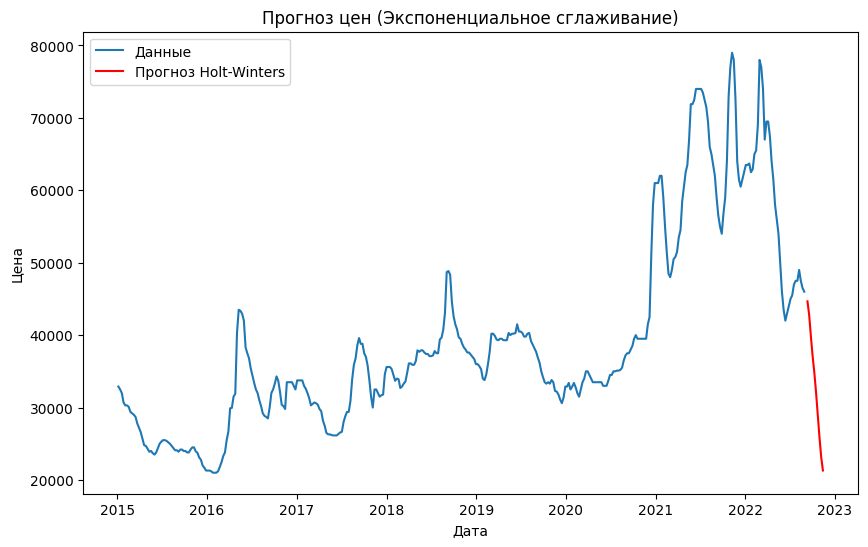

            Forecast
2022-09-11       NaN
2022-09-18       NaN
2022-09-25       NaN
2022-10-02       NaN
2022-10-09       NaN
2022-10-16       NaN
2022-10-23       NaN
2022-10-30       NaN
2022-11-06       NaN
2022-11-13       NaN


In [105]:
model_hw = ExponentialSmoothing(ca['price'], trend='add', seasonal='add', seasonal_periods=52)
model_hw_fit = model_hw.fit()

forecast_hw = model_hw_fit.forecast(steps=10)
plt.figure(figsize=(10, 6))
plt.plot(ca.index, ca['price'], label='Данные')
plt.plot(pd.date_range(ca.index[-1], periods=11, freq='W')[1:], forecast_hw, label='Прогноз Holt-Winters', color='red')
plt.title("Прогноз цен (Экспоненциальное сглаживание)")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.show()

forecast_df_hw = pd.DataFrame(forecast_hw, index=pd.date_range(ca.index[-1], periods=11, freq='W')[1:], columns=['Forecast'])
print(forecast_df_hw)

Ага! Обнаружены NaN. Пробуем несколько моделей

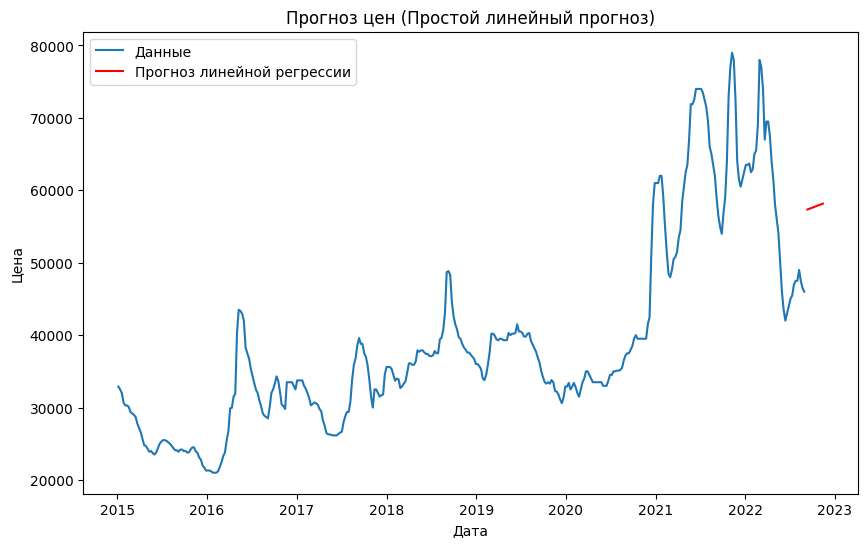

                Forecast
2022-09-11  57347.680075
2022-09-18  57438.045188
2022-09-25  57528.410300
2022-10-02  57618.775413
2022-10-09  57709.140526
2022-10-16  57799.505638
2022-10-23  57889.870751
2022-10-30  57980.235863
2022-11-06  58070.600976
2022-11-13  58160.966089


In [106]:
X = np.arange(len(ca)).reshape(-1, 1) 
y = ca['price'].values  

model_lr = LinearRegression()
model_lr.fit(X, y)

future_weeks = np.arange(len(ca), len(ca) + 10).reshape(-1, 1)
forecast_lr = model_lr.predict(future_weeks)

plt.figure(figsize=(10, 6))
plt.plot(ca.index, ca['price'], label='Данные')
plt.plot(pd.date_range(ca.index[-1], periods=11, freq='W')[1:], forecast_lr, label='Прогноз линейной регрессии', color='red')
plt.title("Прогноз цен (Простой линейный прогноз)")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.show()

forecast_df_lr = pd.DataFrame(forecast_lr, index=pd.date_range(ca.index[-1], periods=11, freq='W')[1:], columns=['Forecast'])
print(forecast_df_lr)

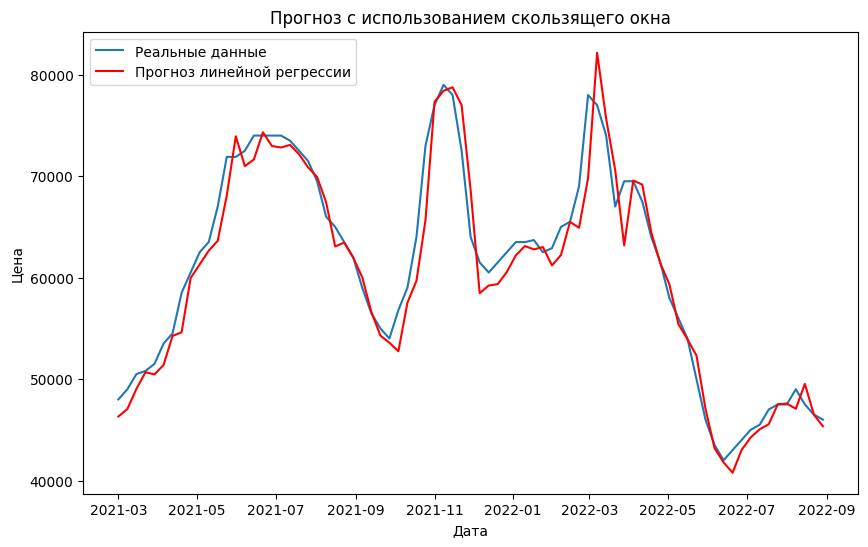

                Forecast
2022-09-11  45663.357492
2022-09-18  45355.086105
2022-09-25  45055.498587
2022-10-02  44763.692563
2022-10-09  44479.668033
2022-10-16  44203.424997
2022-10-23  43934.963455
2022-10-30  43673.310720
2022-11-06  43419.439479
2022-11-13  43172.377046


In [107]:
def create_features(data, window_size=5):
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])  
        y.append(data[i])  
    return np.array(X), np.array(y)

X, y = create_features(ca['price'].values, window_size=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(ca.index[-len(y_test):], y_test, label='Реальные данные')
plt.plot(ca.index[-len(y_test):], y_pred, label='Прогноз линейной регрессии', color='red')
plt.title("Прогноз с использованием скользящего окна")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.show()


future_X = ca['price'].values[-5:]  
future_X = future_X.reshape(1, -1)

forecast_window = []
for i in range(10):
    next_forecast = model.predict(future_X)
    forecast_window.append(next_forecast[0])
    future_X = np.roll(future_X, shift=-1)
    future_X[-1] = next_forecast[0]

forecast_df_window = pd.DataFrame(forecast_window, index=pd.date_range(ca.index[-1], periods=11, freq='W')[1:], columns=['Forecast'])
print(forecast_df_window)

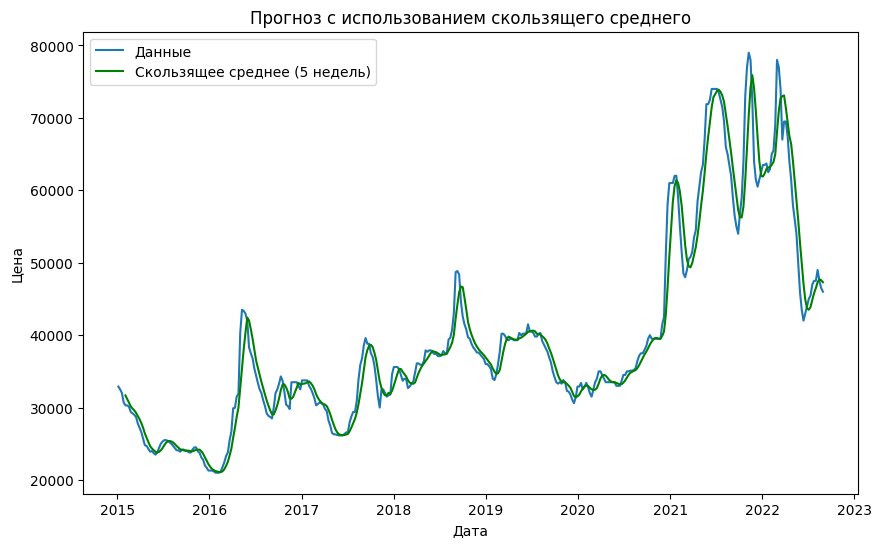

In [108]:
window_size = 5
ca['rolling_mean'] = ca['price'].rolling(window=window_size).mean()


plt.figure(figsize=(10, 6))
plt.plot(ca.index, ca['price'], label='Данные')
plt.plot(ca.index, ca['rolling_mean'], label=f'Скользящее среднее ({window_size} недель)', color='green')
plt.title("Прогноз с использованием скользящего среднего")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.show()

In [109]:
print(ca['price'].dtype)

ca['price'] = pd.to_numeric(ca['price'], errors='coerce')

print(ca['price'].isnull().sum())

ca['price'] = ca['price'].fillna(method='ffill')


int64
0


C:\Users\User\AppData\Local\Temp\ipykernel_10176\2979728725.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ca['price'] = ca['price'].fillna(method='ffill')


c:\Users\User\Documents\GitHub\Intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\User\Documents\GitHub\Intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


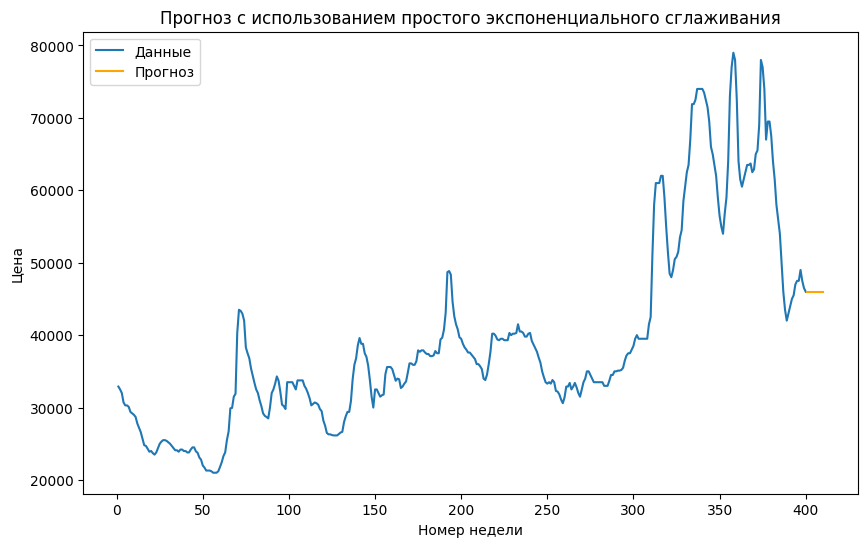

     Forecast
401       NaN
402       NaN
403       NaN
404       NaN
405       NaN
406       NaN
407       NaN
408       NaN
409       NaN
410       NaN


In [ ]:
ca['week_num'] = range(1, len(ca) + 1)

X = ca['week_num']
y = ca['price']

model_simple = sm.tsa.SimpleExpSmoothing(y)
model_simple_fit = model_simple.fit()

forecast_simple = model_simple_fit.forecast(steps=10)

plt.figure(figsize=(10, 6))
plt.plot(ca['week_num'], y, label='Данные')
plt.plot(range(len(ca) + 1, len(ca) + 11), forecast_simple, label='Прогноз', color='orange')
plt.title("Прогноз с использованием простого экспоненциального сглаживания")
plt.xlabel("Номер недели")
plt.ylabel("Цена")
plt.legend()
plt.show()

forecast_df_simple = pd.DataFrame(forecast_simple, columns=['Forecast'], index=range(len(ca) + 1, len(ca) + 11))
print(forecast_df_simple)

Выглядит ОЧЕНЬ странно, надо понять откуда берутся NaN.